Author: Thomas Baratta

Analysis Task 1

Objective: Find the ratios of each cue type from each image to find which cues are being chosen most frequnetly with respect to each image.

Approach: We can do this by dividing the sum of each cue types that were chosen and divide them by the total amount of users that labeled an image.

In [5]:
import psycopg2 #for database connection
import pandas as pd 
import sqlalchemy
import numpy as np
import matplotlib.pyplot as plt # for plotting
import json

In [6]:
# Define database
hostname = 'localhost'
username = 'postgres'
password = ''
database = 'PhishFinder'
port = 5432

In [7]:
# Create Connection
try:
    connection = psycopg2.connect( host=hostname, user=username, password=password, dbname=database, port=port )
    
    
except:
    print("I am unable to connect to the database")

In [8]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [9]:
# We will be using gold standard images 

df = pd.read_sql_query("select subject_id, filename, malicious, gold_std from cybertrust_zooniverse_datamatch where gold_std is true", connection)

df.head()

/var/folders/_k/jy17ssg501sdrndxbhhltw0c0000gn/T/ipykernel_69993/4204450350.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select subject_id, filename, malicious, gold_std from cybertrust_zooniverse_datamatch where gold_std is true", connection)


,subject_id,filename,malicious,gold_std
0,43857918,BoA2(1).jpg,True,True
1,43861756,GoogleDoc.jpg,True,True
2,43857092,UPRailRoad.png,False,True
3,43857086,TaxInformationEmail.png,True,True
4,43857079,Paypal.png,True,True


In [10]:
if 'subject_id' in df.columns:
    print("'subject_id' is a column in df")
else:
    print("'subject_id' is not a column in df")


'subject_id' is a column in df


In [11]:
query = """
    SELECT
      l2.obj ->> 'x' AS x,
      l2.obj ->> 'y' AS y,
      (l2.obj ->> 'width')::float AS width,
      (l2.obj ->> 'height')::float AS height,
      l2.obj ->> 'tool_label' AS tool_label,
      c.subject_ids AS subject_ids
    FROM
      zooniverse_phish_classifications c,
      LATERAL jsonb_array_elements(annotations) AS l1(obj),
      LATERAL jsonb_array_elements(l1.obj->'value') AS l2(obj)
    WHERE
      l1.obj ->> 'task' = 'T0';
"""

json_df = pd.read_sql_query(query, connection)
json_df.head()

/var/folders/_k/jy17ssg501sdrndxbhhltw0c0000gn/T/ipykernel_69993/3277221785.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  json_df = pd.read_sql_query(query, connection)


,x,y,width,height,tool_label,subject_ids
0,751.80126953125,360.06317138671875,206.822510,30.445953,Invalid Domain or Sender,43857089
1,1340.909423828125,536.3096923828125,837.788574,245.667297,Appeal to Action-Urgency,43857089
2,967.4993286132812,359.9391174316406,216.079895,31.109283,Invalid Domain or Sender,43857095
3,1367.5826416015625,776.6834106445312,873.829468,18.075012,Appeal to Action-Urgency,43857095
4,1277.9254150390625,800.5612182617188,449.304321,33.966675,Appeal to Action-Urgency,43857095


In [12]:
# Lets sum all the cues together for each subject_id
# tool_label => cue type 
query = """
    SELECT
  c.subject_ids AS subject_ids,
  l2.obj ->> 'tool_label' AS tool_label,
  COUNT(*) AS tool_label_count
FROM
  zooniverse_phish_classifications c,
  LATERAL jsonb_array_elements(c.annotations) AS l1(obj),
  LATERAL jsonb_array_elements(l1.obj->'value') AS l2(obj)
WHERE
  l1.obj ->> 'task' = 'T0'
GROUP BY
  c.subject_ids,
  l2.obj ->> 'tool_label';
"""

sum_df = pd.read_sql_query(query, connection)
sum_df.head()

/var/folders/_k/jy17ssg501sdrndxbhhltw0c0000gn/T/ipykernel_69993/3795369252.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sum_df = pd.read_sql_query(query, connection)


,subject_ids,tool_label,tool_label_count
0,43856939,Appeal to Action-Greed,5
1,43856939,Invalid Domain or Sender,1
2,43856939,Other Phishy Findings,1
3,43856944,Appeal to Action-Greed,5
4,43856944,Invalid Domain or Sender,9


In [13]:
query = """
    WITH ToolLabelCounts AS (
  SELECT
    c.subject_ids AS subject_ids,
    l2.obj ->> 'tool_label' AS tool_label,
    COUNT(*) AS tool_label_count
  FROM
    zooniverse_phish_classifications c,
    LATERAL jsonb_array_elements(annotations) AS l1(obj),
    LATERAL jsonb_array_elements(l1.obj->'value') AS l2(obj)
  WHERE
    l1.obj ->> 'task' = 'T0'
  GROUP BY
    c.subject_ids,
    l2.obj ->> 'tool_label'
)

SELECT
  tlc.subject_ids,
  tlc.tool_label,
  tlc.tool_label_count,
  100.0 * tlc.tool_label_count / SUM(tlc.tool_label_count) OVER (PARTITION BY tlc.subject_ids) AS tool_label_percentage
FROM
  ToolLabelCounts tlc;

"""

ratio_df = pd.read_sql_query(query, connection)
ratio_df.head()

/var/folders/_k/jy17ssg501sdrndxbhhltw0c0000gn/T/ipykernel_69993/2266777887.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratio_df = pd.read_sql_query(query, connection)


,subject_ids,tool_label,tool_label_count,tool_label_percentage
0,43856939,Appeal to Action-Greed,5,71.428571
1,43856939,Invalid Domain or Sender,1,14.285714
2,43856939,Other Phishy Findings,1,14.285714
3,43856944,Appeal to Action-Greed,5,23.809524
4,43856944,Invalid Domain or Sender,9,42.857143


In [14]:
# This dataframe shows us the ratio in % of each cue type used for each subject_id
query = """
    WITH ToolLabelCounts AS (
  SELECT
    c.subject_ids AS subject_ids,
    l2.obj ->> 'tool_label' AS tool_label,
    COUNT(*) AS tool_label_count
  FROM
    zooniverse_phish_classifications c,
    LATERAL jsonb_array_elements(annotations) AS l1(obj),
    LATERAL jsonb_array_elements(l1.obj->'value') AS l2(obj)
  WHERE
    l1.obj ->> 'task' = 'T0'
  GROUP BY
    c.subject_ids,
    l2.obj ->> 'tool_label'
)

SELECT
  tlc.subject_ids,
  tlc.tool_label,
  tlc.tool_label_count,
  CONCAT(ROUND(100.0 * tlc.tool_label_count / SUM(tlc.tool_label_count) OVER (PARTITION BY tlc.subject_ids), 2), '%') AS tool_label_percentage
FROM
  ToolLabelCounts tlc;

"""

ratio_df_v2 = pd.read_sql_query(query, connection)
ratio_df_v2.head()

/var/folders/_k/jy17ssg501sdrndxbhhltw0c0000gn/T/ipykernel_69993/2356538465.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratio_df_v2 = pd.read_sql_query(query, connection)


,subject_ids,tool_label,tool_label_count,tool_label_percentage
0,43856939,Appeal to Action-Greed,5,71.43%
1,43856939,Invalid Domain or Sender,1,14.29%
2,43856939,Other Phishy Findings,1,14.29%
3,43856944,Appeal to Action-Greed,5,23.81%
4,43856944,Invalid Domain or Sender,9,42.86%


In [15]:
# This DataFrame will display the ratios of each cue type using gold_std images
# Fetching ratio_df_v2 
query = """
    WITH ToolLabelCounts AS (
        SELECT
            c.subject_ids AS subject_ids,
            l2.obj ->> 'tool_label' AS tool_label,
            COUNT(*) AS tool_label_count
        FROM
            zooniverse_phish_classifications c,
            LATERAL jsonb_array_elements(annotations) AS l1(obj),
            LATERAL jsonb_array_elements(l1.obj->'value') AS l2(obj)
        WHERE
            l1.obj ->> 'task' = 'T0'
        GROUP BY
            c.subject_ids,
            l2.obj ->> 'tool_label'
    )

    SELECT
        tlc.subject_ids,
        tlc.tool_label,
        tlc.tool_label_count,
        CONCAT(ROUND(100.0 * tlc.tool_label_count / SUM(tlc.tool_label_count) OVER (PARTITION BY tlc.subject_ids), 2), '%') AS tool_label_percentage
    FROM
        ToolLabelCounts tlc;
"""

ratio_df_v2 = pd.read_sql_query(query, connection)

# Fetching df 
df = pd.read_sql_query("SELECT subject_id, filename, malicious, gold_std FROM cybertrust_zooniverse_datamatch WHERE gold_std IS TRUE", connection)

# Cast 'subject_ids' to integer
ratio_df_v2['subject_ids'] = ratio_df_v2['subject_ids'].astype(int)

# Merging the two DataFrames on the 'subject_ids' and 'subject_id' columns
merged_df = pd.merge(ratio_df_v2, df, left_on='subject_ids', right_on='subject_id', how='inner')

# Dropping redundant 'subject_ids' column after merging
merged_df = merged_df.drop(columns=['subject_ids'])

# Displaying the merged DataFrame
styled_merged_df = merged_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

styled_merged_df


/var/folders/_k/jy17ssg501sdrndxbhhltw0c0000gn/T/ipykernel_69993/2212150775.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratio_df_v2 = pd.read_sql_query(query, connection)
/var/folders/_k/jy17ssg501sdrndxbhhltw0c0000gn/T/ipykernel_69993/2212150775.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT subject_id, filename, malicious, gold_std FROM cybertrust_zooniverse_datamatch WHERE gold_std IS TRUE", connection)


,tool_label,tool_label_count,tool_label_percentage,subject_id,filename,malicious,gold_std
0,Appeal to Action-Authority,1,5.26%,43857060,Box.png,True,True
1,Appeal to Action-Urgency,8,42.11%,43857060,Box.png,True,True
2,Invalid Domain or Sender,6,31.58%,43857060,Box.png,True,True
3,Poor Spelling or Grammar,1,5.26%,43857060,Box.png,True,True
4,Potentially Malicious Link,3,15.79%,43857060,Box.png,True,True
5,Invalid Domain or Sender,2,28.57%,43857061,craigslist.png,True,True
6,Other Phishy Findings,1,14.29%,43857061,craigslist.png,True,True
7,Poor Spelling or Grammar,4,57.14%,43857061,craigslist.png,True,True
8,Appeal to Action-Authority,1,4.76%,43857063,Discover.png,True,True
9,Appeal to Action-Urgency,1,4.76%,43857063,Discover.png,True,True


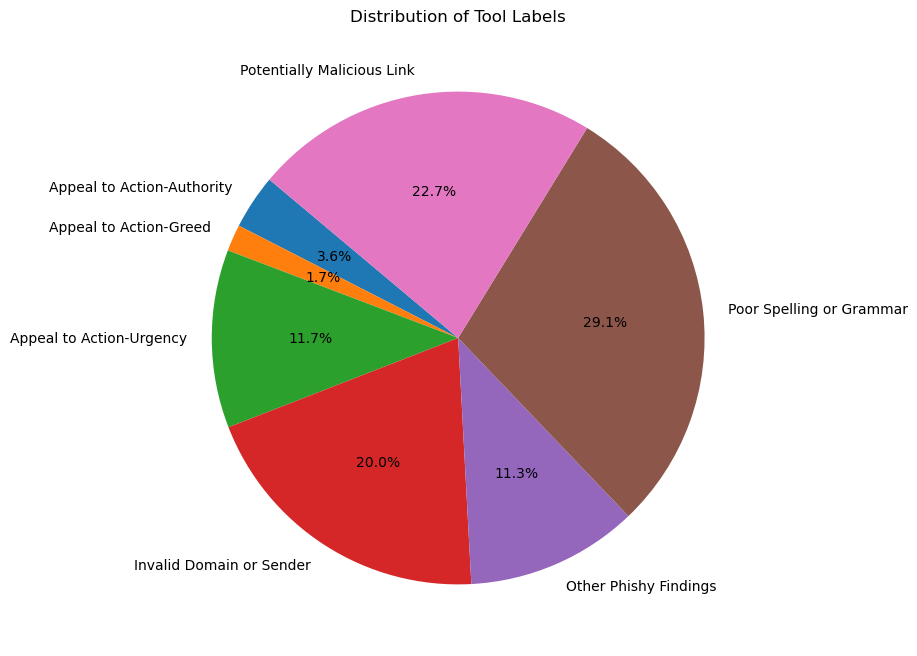

In [16]:
# Grouping by 'tool_label' and summing the counts
pie_data_count = merged_df.groupby('tool_label')['tool_label_count'].sum()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(pie_data_count, labels=pie_data_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Tool Labels')
plt.show()

/var/folders/_k/jy17ssg501sdrndxbhhltw0c0000gn/T/ipykernel_69993/1956440238.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 6))


AttributeError: module 'matplotlib.pyplot' has no attribute 'make_image'

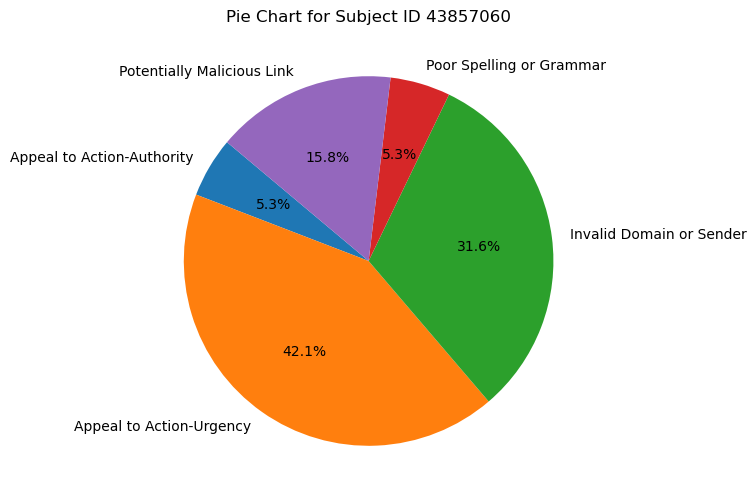

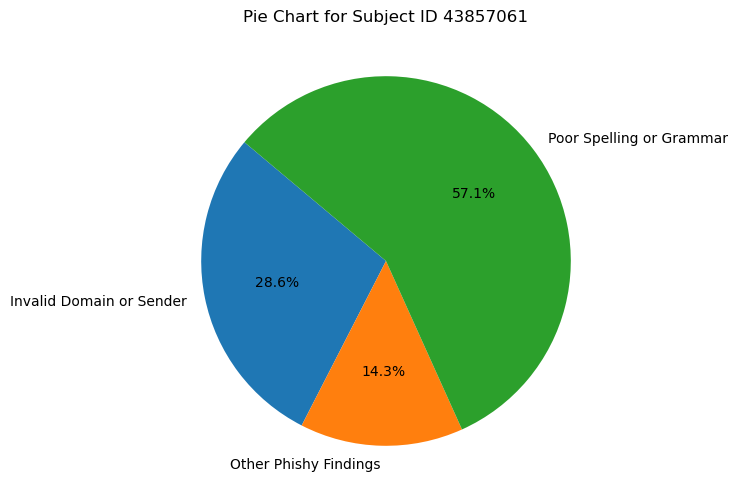

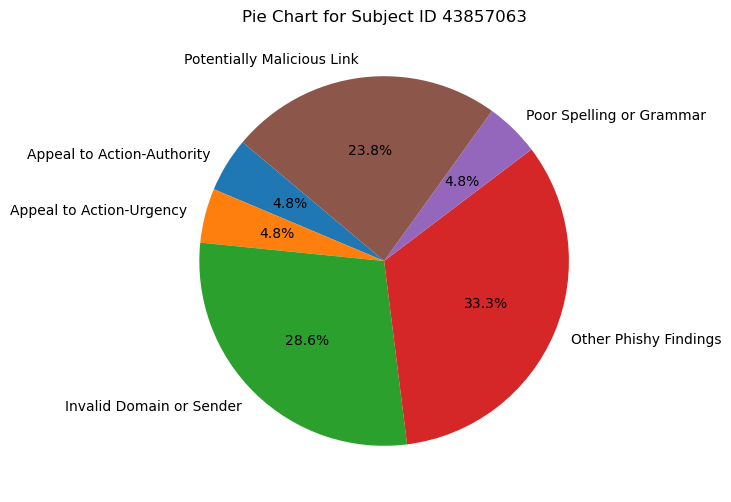

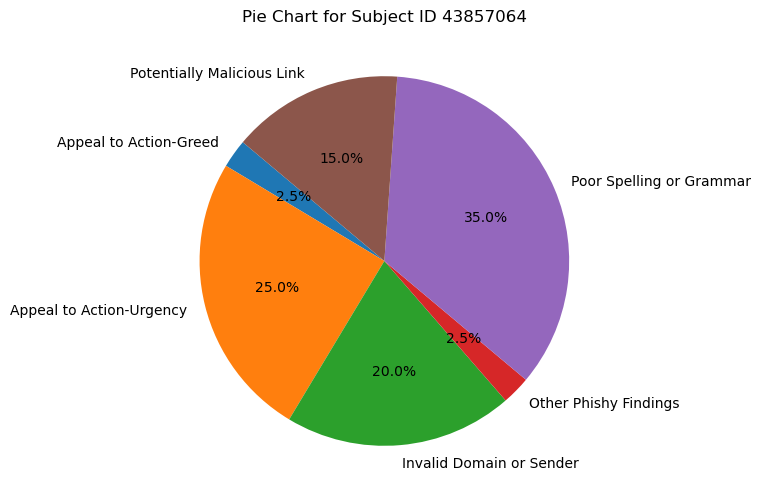

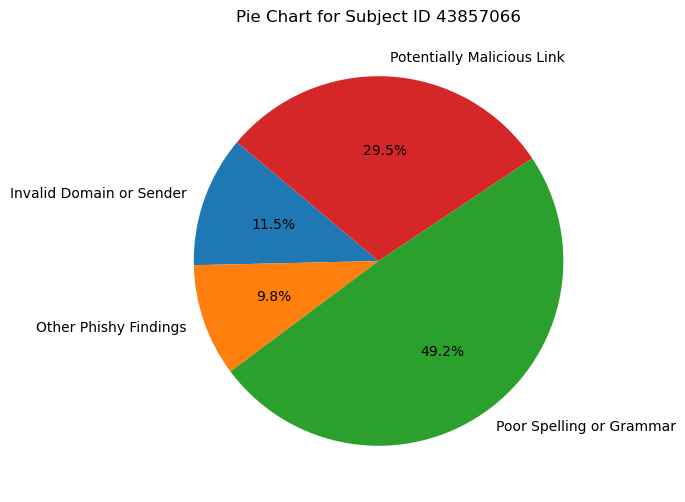

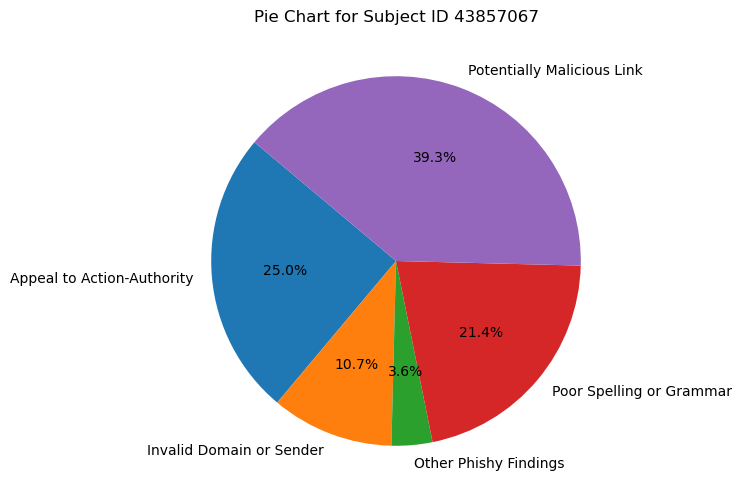

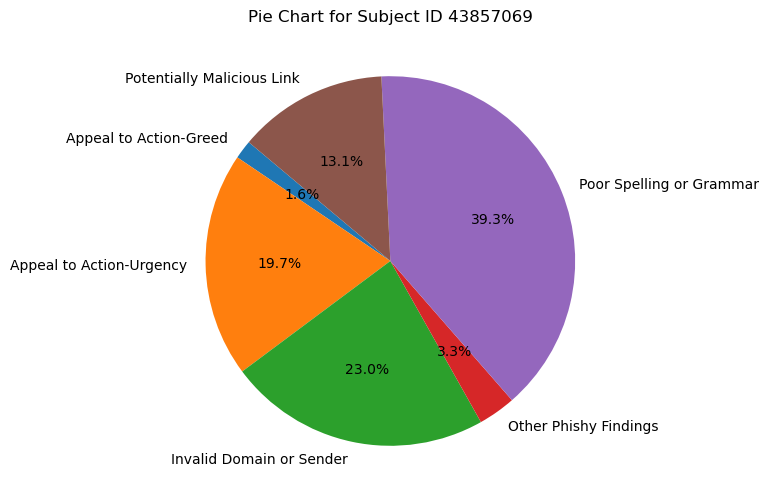

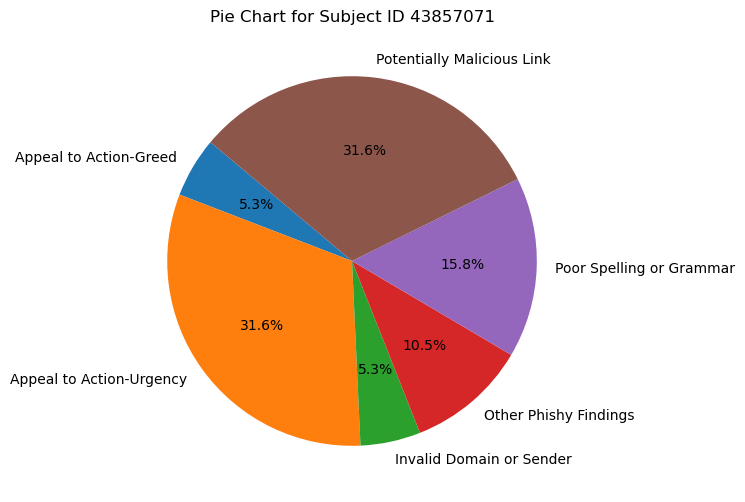

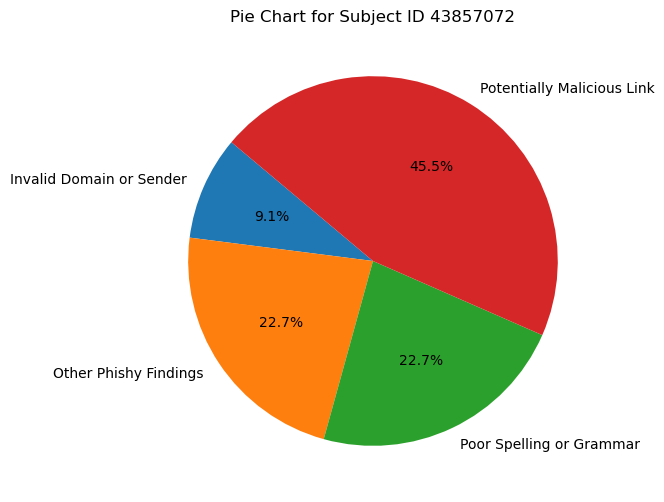

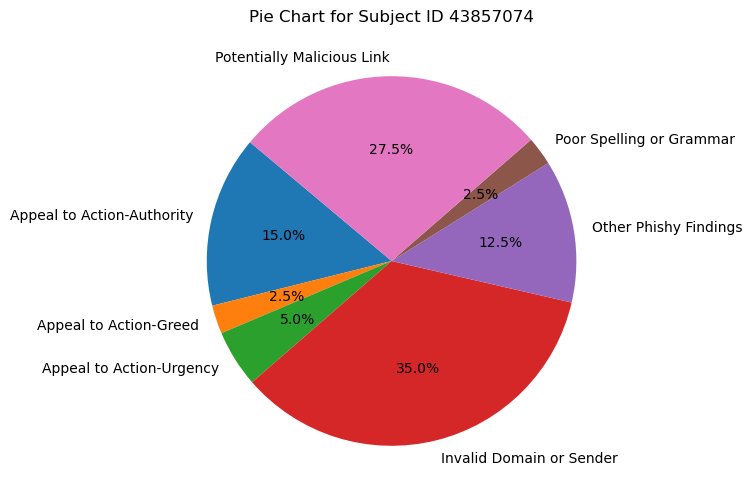

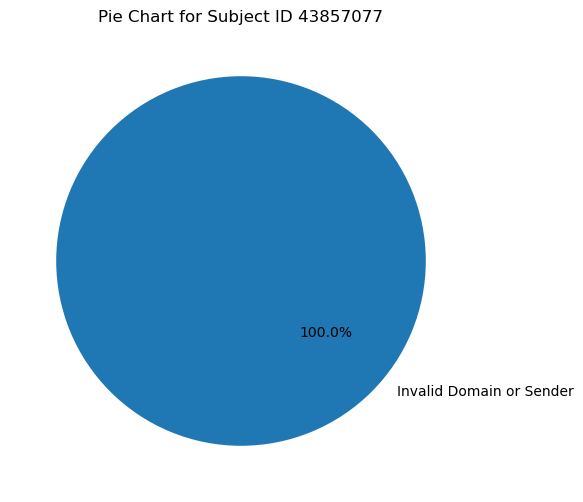

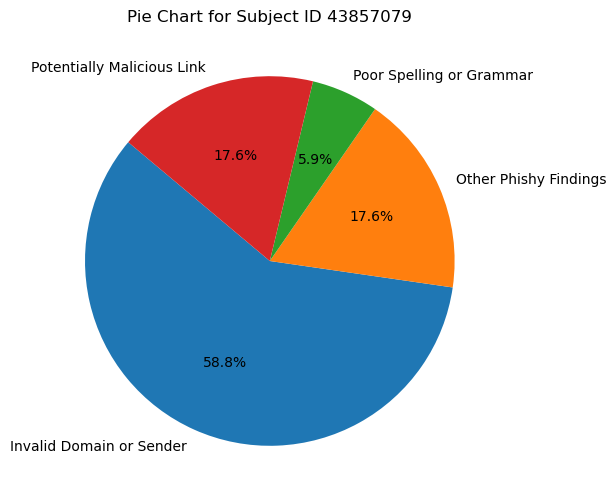

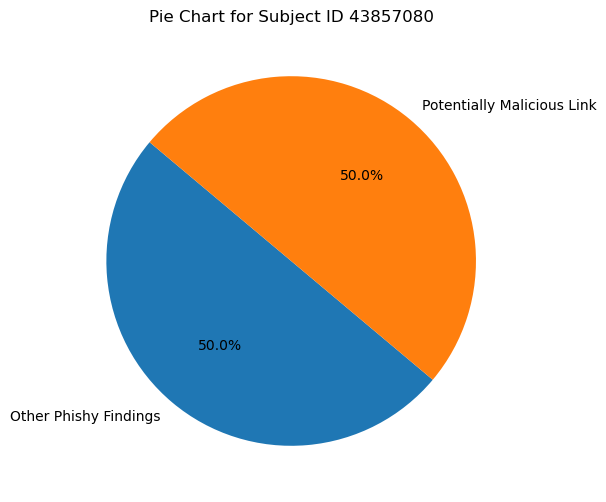

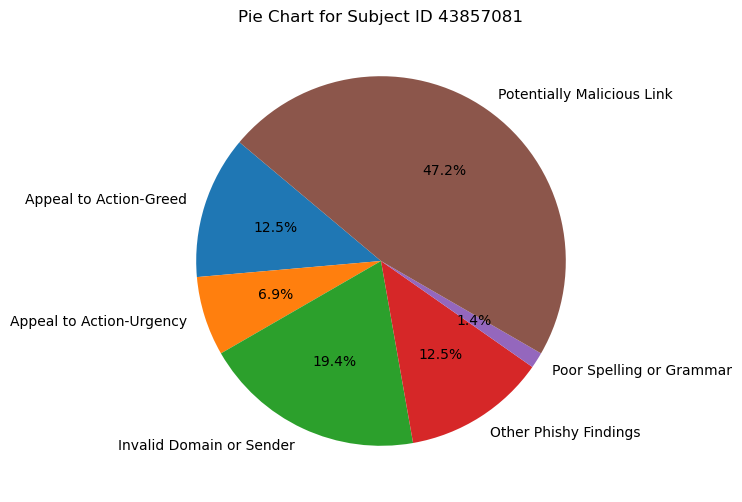

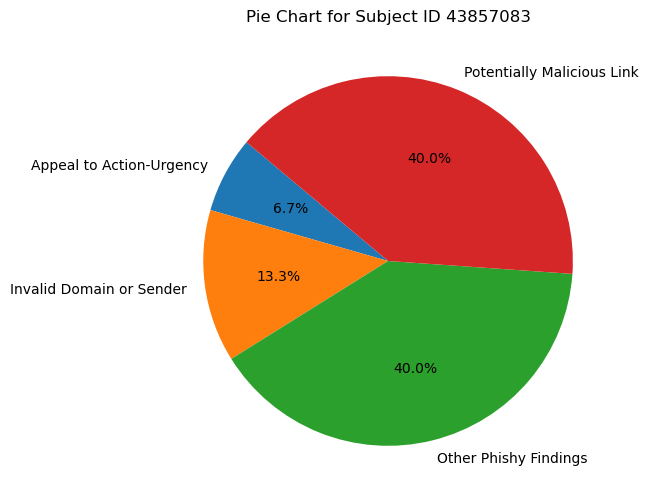

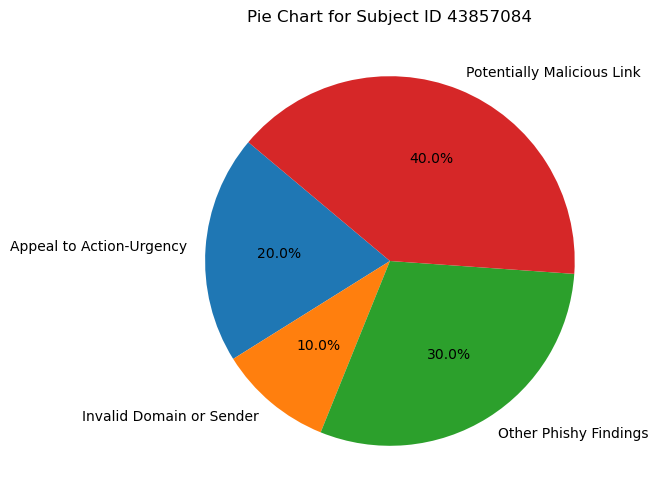

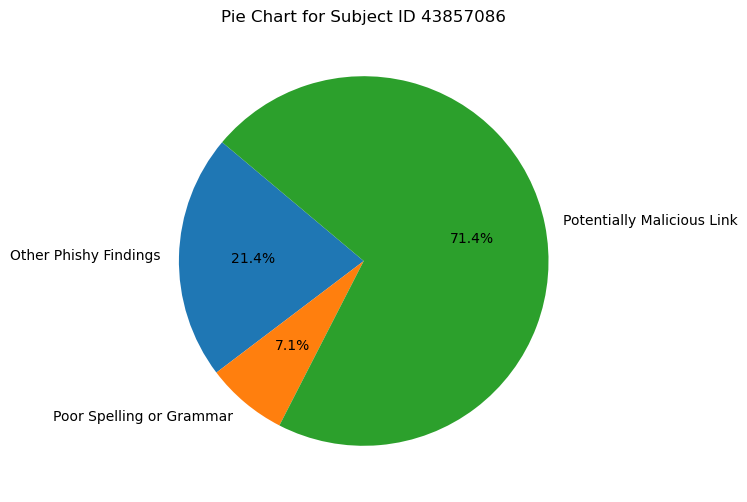

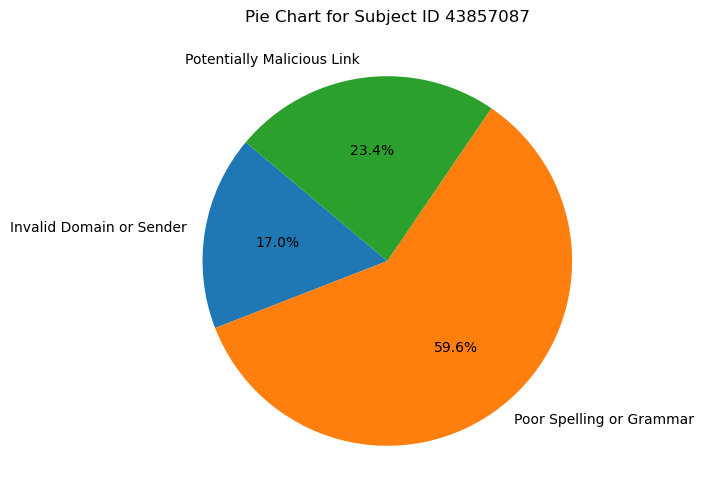

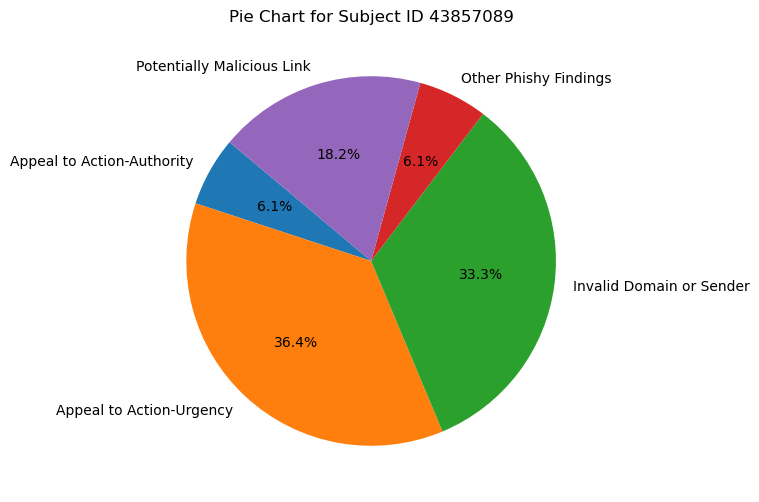

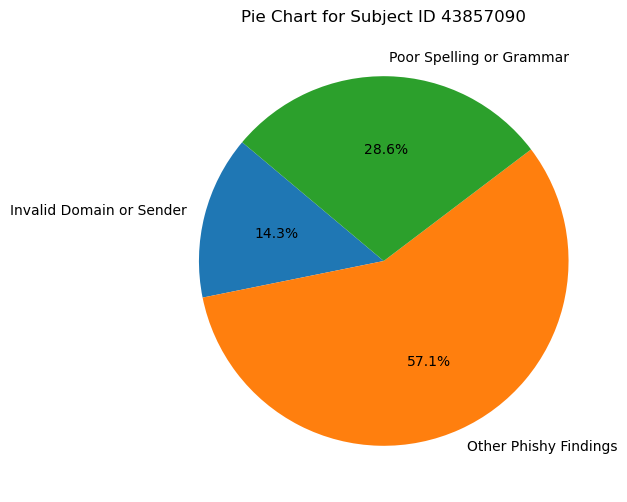

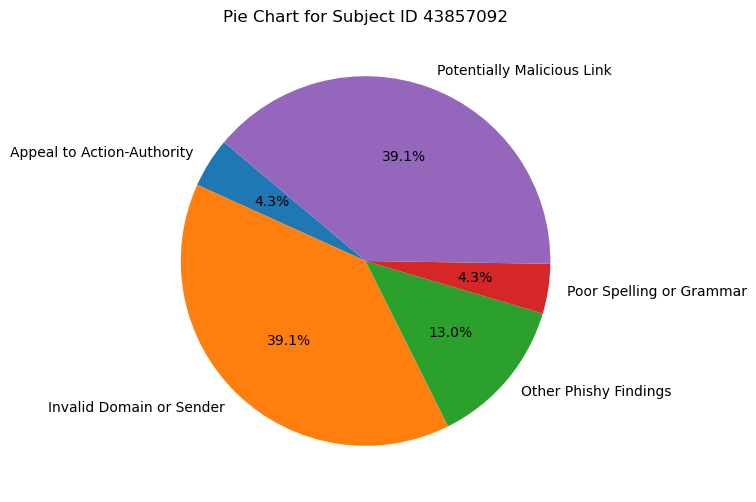

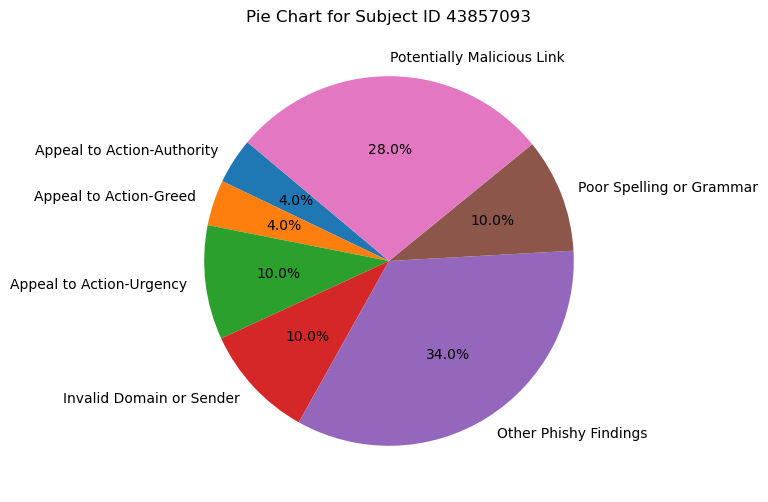

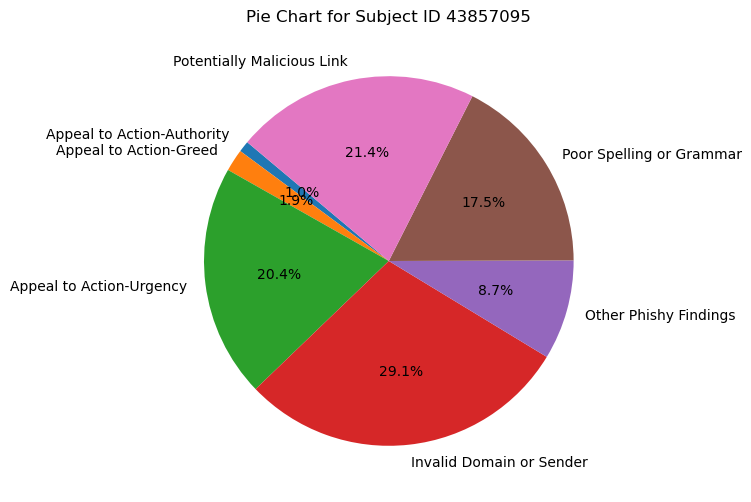

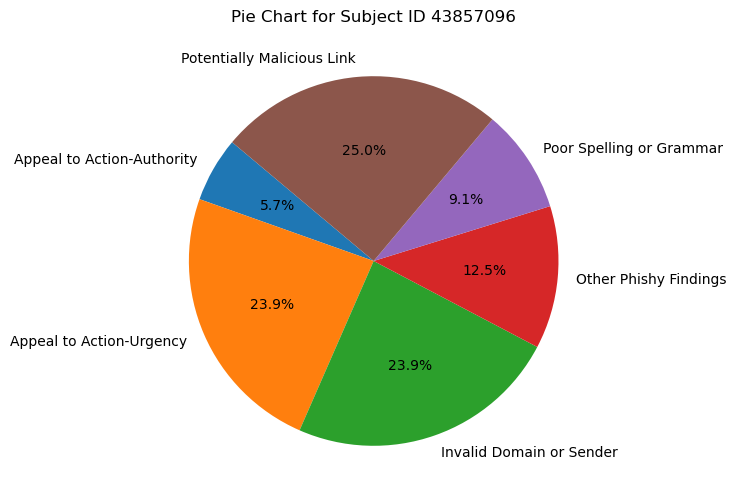

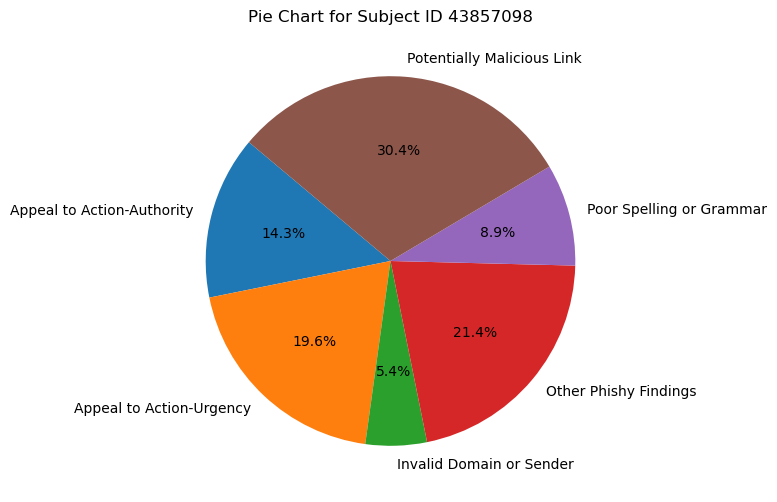

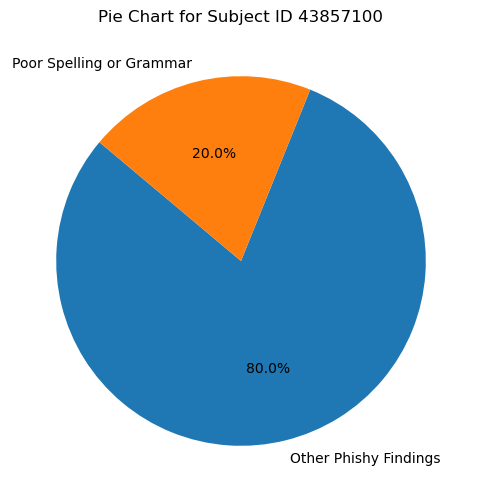

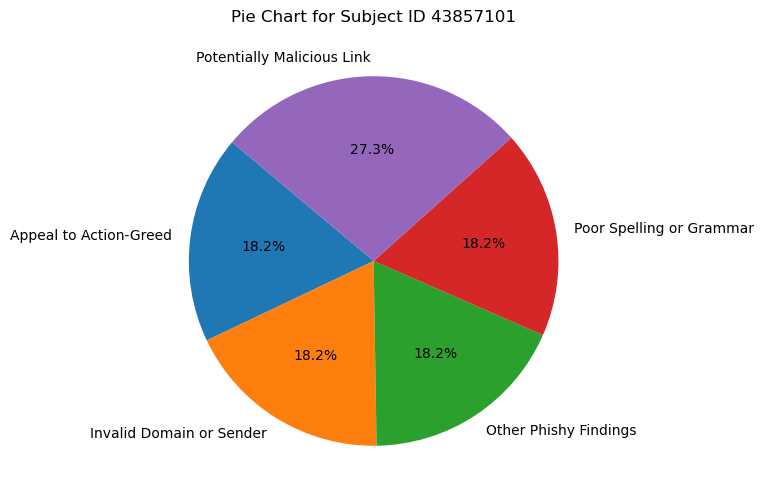

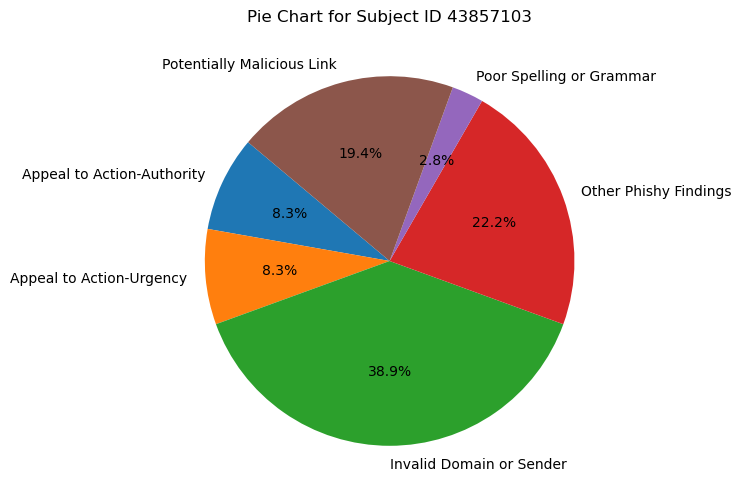

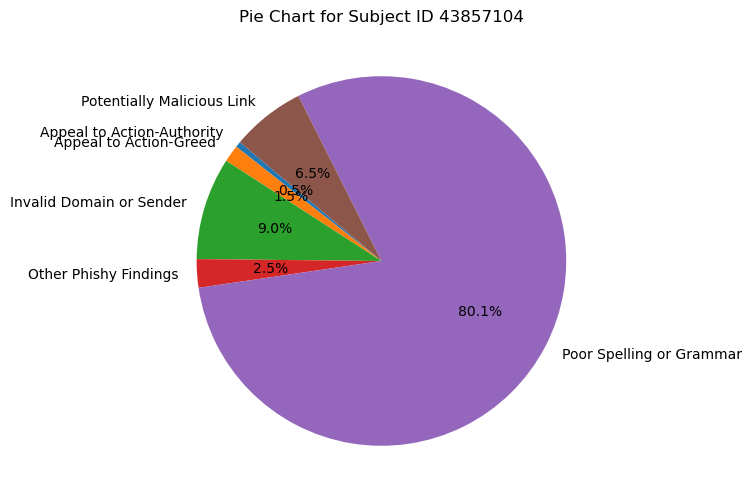

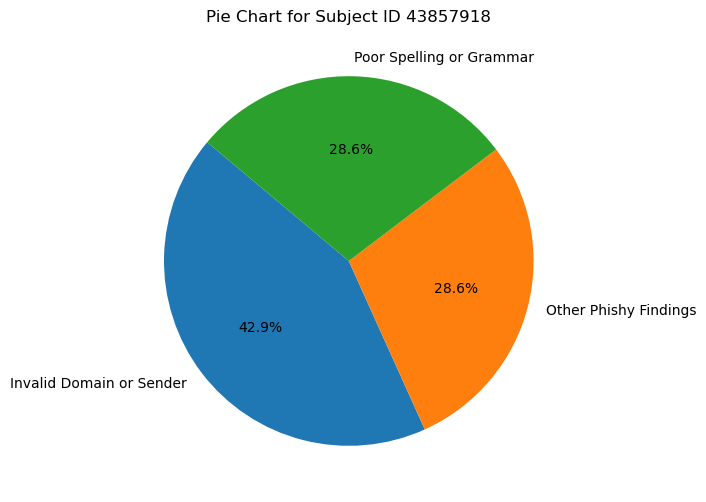

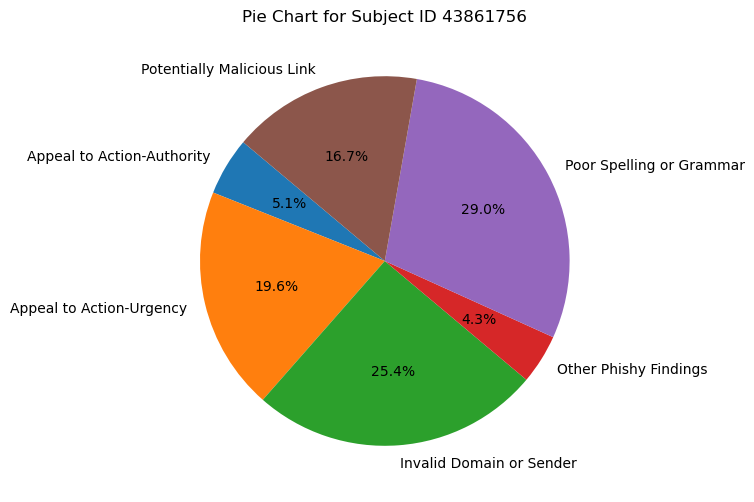

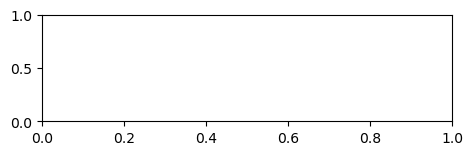

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming 'tool_label_percentage' is a string with percentage values (e.g., '25%')
merged_df['tool_label_percentage'] = merged_df['tool_label_percentage'].replace({'%': ''}, regex=True).astype('float') / 100.0

# Grouping by 'subject_id' and 'tool_label' and summing the counts
grouped_data = merged_df.groupby(['subject_id', 'tool_label'])['tool_label_count'].sum().reset_index()

# Creating a pie chart for each subject_id and saving them to a list
pie_charts = []
for subject_id, data in grouped_data.groupby('subject_id'):
    plt.figure(figsize=(6, 6))
    plt.pie(data['tool_label_count'], labels=data['tool_label'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Pie Chart for Subject ID {subject_id}')
    pie_charts.append(plt)

# Combining all pie charts into one image
big_fig = plt.figure(figsize=(18, 18))
for i, pie_chart in enumerate(pie_charts, start=1):
    big_fig.add_subplot(len(pie_charts)//3 + 1, 3, i)
    plt.imshow(pie_chart.make_image())
    plt.axis('off')

plt.tight_layout()
plt.show()
